# Math 266 Chaos Homework (Part 2)

In [1]:
import copy
import datetime
import functools
from IPython.display import HTML
import itertools
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from pathlib import Path
from scipy import stats
from scipy.linalg import qr, eig
# from scipy.integrate import odeint # use solve_ivp instead
from scipy.integrate import solve_ivp
import seaborn as sns
import skimage.measure
import statsmodels.api as sm 
import statsmodels.formula.api as smf

%matplotlib inline
# sns.set()

# I love u autoreload!
%load_ext autoreload
%autoreload 2

## Box Counting Dimension

Not yet used to estimate the dimension of the fractals for different alphas.

In [2]:
# Source of code: fern.m, serpinski.m, koch.m, and boxcount.m

def slope(x, y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return slope

def boxcount(points, max_steps, method='boolean', show_plot=True):
    '''
    points: an (n, 2) matrix, where each row is the x,y value of a point.
    max_steps: the maximum number of steps of the box counting method.
    method: 'unique' counts the unique box indices of the points. 
      'boolean' counts the boxes by uses box indices of the points
      to set the elements of a grid of boxes and then sum the grid.
      'set' is like unique but avoids sorting the box indices of the
      points by iterating over the points and adding their indices to
      a set. The length of the set is the number of occupied boxes.
      
    I think 'boolean' should scale with (2**(max_steps-1))**ndims (the number
    of boxes in the box grid that needs to be allocated.)
    I think 'unique' should scale with ~nlog(n), where n=len(points), due to sorting the
    indices of the points.
    I think 'set' should scale with len(points) by using a set instead of sorting. But
    the overhead of the implementation makes it slower for ranges I've tested.
    '''
    ndim = points.shape[1] # e.g. 2d or 3d.
    dmin = points.min(axiss=0) # min value of each dimension
    dmax = points.max(axis=0)
    drange = dmax - dmin
    x = np.zeros(max_steps + 1) # data for the least squares method
    y = np.zeros(max_steps + 1) # data for the least squares method
    for step in range(max_steps + 1):
        nbox = 2**step # number of boxes in each direction
        dbox = drange / nbox # box dimensions
        # indices of box containing each point
        box_idx = ((points - dmin) // dbox).astype(int) # int index of each point in boxes
        # special case: point/s with max dims should have a box index of nbox - 1, not nbox
        box_idx = np.where(box_idx == nbox, nbox - 1, box_idx)
        
        if method == 'boolean':
            # convert box_idx into a integer index
            box_idx = tuple(box_idx.T)
#             box_idx = ((points - dmin) // dbox).T.astype(int) # int index of each point in boxes
#             # special case: point/s with max dims should have a box index of nbox - 1, not nbox
#             box_idx = tuple(np.where(box_idx == nbox, nbox - 1, box_idx))
            # count occupied boxes
            # 0 if no point in box, 1 if point in box
            boxes = np.zeros([nbox]*ndim) 
            boxes[box_idx] = 1
            n_boxes = boxes.sum() # count all occupied boxes
        elif method == 'unique':
            # count occupied boxes
            n_boxes = len(np.unique(box_idx, axis=0))
        elif method == 'set':
            box_set = set()
            for i in range(len(box_idx)):
                box_set.add(tuple(box_idx[i]))
                
            n_boxes = len(box_set)

        x[step] = step * log(2); # log(1/epsilon), where epsilon ~ 2**step
        y[step] = log(n_boxes); # log(N(epsilon))
        print(step, len(points), n_boxes, nbox**points.shape[1], n_boxes / nbox**points.shape[1], y[step] / x[step])
        
    # To estimate the fractal dimension, the slope of the line 
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    frac_dim = slope
    
    if show_plot:
        dim_x = [x.min(), x.max()]
        dim_y = [x.min() * slope + intercept, x.max() * slope + intercept]
        plt.title(f'log(N(epsilon)) vs log(1/epsilon). Box Counting Dim: {slope:.4}')
        plt.plot(dim_x, dim_y)
        plt.plot(x, y, '.')
        plt.xlabel('log(1/epsilon)')
        plt.ylabel('log(N(epsilon))')
        plt.show()
    
    return frac_dim



## Sierpinski Populations

The [Chaos Game](https://en.wikipedia.org/wiki/Sierpi%C5%84ski_triangle#Chaos_game) is an algorithm for generating an infinite set of points on the invariant set of the Sierpinski Triangle. 

The game can be generalized by parameterizing:

- alpha, the step size, $\alpha$ such that $0 \leq \alpha \leq 1$. The Sierpinski Triangle step size is 0.5.
- A, the anchor points that attract the point during iteration. The Sierpinski Triangle uses the corners of a triangle.

In these methods, the anchor points are distributed uniformly around the unit circle to create regular polygons: a segment, a triangle, a square, a pentagon, etc.

Let a population, P, be a set of points in $\mathbb{R}^d$, parameter space. The initial population is drawn at random from the anchor points. During iteration a child population is created from a parent population. Each child population member takes a step halfway from its corresponding parent toward a randomly selected anchor point.

In [3]:
def initial_2d_sierpinski_points(n):
    radians = np.arange(n) * (2 * np.pi / n)
    xs = np.cos(radians)
    ys = np.sin(radians)
    points = np.stack([xs, ys], axis=1)
    return points


class SierpinskiPopulation:
    def __init__(self, anchors=None, pop_size=1, method='initial', alpha=0.5):
        '''
        anchors: An 2-dimensional array of anchor points. The shape is (number of achor points, point dimensionality).
          Defaults to the 3 corner points of a 2d triangle (for Sierpinski's Triangle.)
        pop_size: the size of the population of points being iterated at each step.
        method: 'initial': At each step, every member of the population steps halfway
          toward a randomly chosen inital point.
          'current': At each step, every member of the population steps halfway toward
          a randomly chosen current population member.
        alpha: the learning rate or step size. By default 0.5, a new point is halfway between the current
        point and a randomly selected point (an anchor or population member)
        '''
        self.anchors = anchors if anchors is not None else initial_2d_sierpinski_points(3)
        self.size = pop_size if pop_size is not None else len(self.anchors)
        self.method = method # 'initial' population or 'current' population
        self.alpha = alpha # learning rate: size of step toward "correct" point
        
    def reset(self):
        self.pop = self.anchors[np.random.choice(len(self.anchors), size=self.size)]
        self.idx = np.arange(self.size)
        return self.pop
        
    def step(self):
        # choose random parents to step toward
        if self.method == 'initial':
            rand_parents = self.anchors[np.random.choice(len(self.anchors), size=self.size)]
        elif self.method == 'current':
            rand_parents = self.pop[np.random.choice(self.size, size=self.size)]
        else:
            raise Exception('Unrecognized method.', self.method)
            
        # p is a parent  and p' is randomly selected parent or anchor
        # p = (1 - alpha) p + alpha p'
        #   = p + alpha (p' - p)
        self.pop = (1 - self.alpha) * self.pop + self.alpha * rand_parents
        return self.pop
        

def plot_sierpinski_population(anchors, pop_size, num_steps, method, title='Sierpinski Population',
                               s=None, alpha=0.5):
    plt.figure(figsize=(8, 6))
    norm = matplotlib.colors.Normalize(vmin=0,vmax=num_steps)
    s = 0.1 if s is None else s
    def plot_points(points, gen):
        plt.scatter(x=points[:,0], y=points[:,1], c=[gen]*len(points), s=s,
                    norm=norm, cmap='Blues')
        
    pop = SierpinskiPopulation(anchors=anchors,
                                pop_size=pop_size, method=method, alpha=alpha)
    pop_points = []
    plot_points(pop.reset(), gen=0)
    for gen in range(1, num_steps + 1):
        plot_points(pop.step(), gen=gen)
        
    plt.title(title)
    plt.tick_params(bottom=False, top=False, left=False, right=False,
                    labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    plt.show()

def plot_sierpinski_experiment(points_list=[initial_2d_sierpinski_points(3)], pop_sizes=[1],
                               methods=['initial'], num_steps_list=[1000], alphas=[0.5]):
    for points in points_list:
        for method in methods:
            for pop_size in pop_sizes:
                for num_steps in num_steps_list:
                    for alpha in alphas:
                        title = f'Sierpinski Population for {len(points)} Points'
                        title += f'\npopulation: {pop_size}, iterations: {num_steps}'
                        title += f', method: {method}, alpha: {alpha}'
                        plot_sierpinski_population(points, pop_size, num_steps, 
                                                   method=method, title=title, s=1,
                                                   alpha=alpha)
    
def animate_sierpinski_experiment(anchors_list=[initial_2d_sierpinski_points(3)], pop_sizes=[1],
                                  methods=['initial'], num_steps_list=[1000], alphas=[0.5],
                                  s=10, interval=200, filename=None):
    '''
    filename: if not None, save to filename. Otherwise return as HTML
    '''
    # https://stackoverflow.com/questions/9401658/how-to-animate-a-scatter-plot
    
    fig, ax = plt.subplots()
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    s = 0.1 if s is None else s
    scat = ax.scatter(x=[], y=[], c=[], s=s, cmap='Blues')
    def make_title(num_anchors=None, pop_size=None, num_steps=None, method=None, alpha=None):
        alpha = 0 if alpha is None else alpha
        title = f'Sierpinski Population for {num_anchors} Points'
        title += f'\npopulation: {pop_size}, iterations: {num_steps}'
        title += f', method: {method}, alpha: {alpha:.2f}'
        return title
    text = ax.set_title(make_title())
    ax.tick_params(bottom=False, top=False, left=False, right=False,
                    labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    
    params = []
    for anchors in anchors_list:
        for method in methods:
            for pop_size in pop_sizes:
                for num_steps in num_steps_list:
                    for alpha in alphas:
                        params.append((anchors, method, pop_size, num_steps, alpha))

    def init():
        return scat, text

    def animate(params):
#         print('params', params)
        anchors, method, pop_size, num_steps, alpha = params
        pop = SierpinskiPopulation(anchors=anchors,
                                    pop_size=pop_size, method=method, alpha=alpha)
        points = list(pop.reset())
        colors = [0] * pop_size
        for gen in range(1, num_steps + 1):
            points.extend(list(pop.step()))
            colors.extend([gen/num_steps] * pop_size)
            
        scat.set_offsets(np.array(points)) # x, y
        scat.set_sizes(np.full(pop_size * num_steps, s)) # s
        scat.set_array(np.array(colors)) # c
        text.set_text(make_title(num_anchors=len(anchors), pop_size=pop_size,
                                 num_steps=num_steps, method=method, alpha=alpha))
        return scat, text

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=params,
#                                    interval=interval,
                                   blit=True)
    if filename is not None:
        num_frames = len(params)
        fps = int(np.ceil(1000 / interval)) # fps=5
#         writer = animation.FFMpegFileWriter() # fps=5)
        writer = animation.FFMpegWriter(fps=fps)
        return anim.save(filename, writer=writer, dpi=180)
    else:
        return HTML(anim.to_html5_video())



[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42
 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56
 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7
 0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84
 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98
 0.99 1.   1.01 1.02 1.03 1.04 1.05 1.06 1.07 1.08 1.09 1.1  1.11 1.12
 1.13 1.14 1.15 1.16 1.17 1.18 1.19 1.2  1.21 1.22 1.23 1.24 1.25 1.26
 1.27 1.28 1.29 1.3  1.31 1.32 1.33 1.34 1.35 1.36 1.37 1.38 1.39 1.4
 1.41 1.42 1.43 1.44 1.45 1.46 1.47 1.48 1.49 1.5  1.51 1.52 1.53 1.54
 1.55 1.56 1.57 1.58 1.59 1.6  1.61 1.62 1.63 1.64 1.65 1.66 1.67 1.68
 1.69 1.7  1.71 1.72 1.73 1.74 1.75 1.76 1.77 1.78 1.79 1.8  1.81 1.82
 1.83 1.84 1.85 1.86 1.87 1.88 1.89 1.9  1.91 1.92 1.93 1.94 1.95 1.96
 1.97 1.

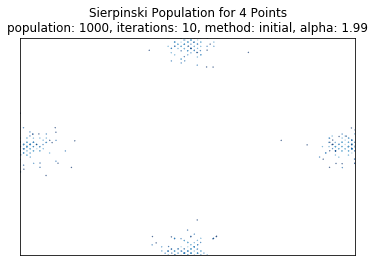

In [4]:
# Plot Sierpinski Population of a line, and triangle, as the Learning Rate is Varied.

# Using the current population as anchors leads to convergence 
# alphas = np.linspace(0.01, 0.99, 99)
alphas = np.linspace(0.01, 1.99, 199)
# alphas = np.linspace(0.1, 0.9, 9)
# alphas = np.linspace(0.1, 1.9, 19)
print(alphas)
pop_sizes = [1000]
num_steps_list = [10]
methods = ['initial']
# anchors_list = [initial_2d_sierpinski_points(i) for i in [16, 25, 100]] # 
anchors_list = [initial_2d_sierpinski_points(i) for i in [4]] # 
for anchors in anchors_list:
    print('num_anchors:', len(anchors))
    # make an animation of the anchors
#     filename = str(Path(f'~/Downloads/{len(anchors)} Point Sierpinski Population as Alpha Varies.mp4').expanduser())
    filename = None
    html = animate_sierpinski_experiment(anchors_list=[anchors], methods=methods, pop_sizes=pop_sizes,
                                         num_steps_list=num_steps_list, alphas=alphas,
                                         filename=filename, s=.1)
    display(html)
                

In [ ]:
# Plot Sierpinski Population of a line, and triangle, as the Learning Rate is Varied.

# Using the current population as anchors leads to convergence 
alphas = np.linspace(0.01, 0.99, 99)
# alphas = np.linspace(0.1, 0.9, 9)
print(alphas)
pop_sizes = [1000]
num_steps_list = [20]
methods = ['initial']
anchors_list = [initial_2d_sierpinski_points(i) for i in list(range(2, 10)) + [16, 25, 100]]
for anchors in anchors_list:
    print('num_anchors:', len(anchors))
    # make an animation of the anchors
#     filename = str(Path(f'~/Downloads/{len(anchors)} Point Sierpinski Population as Alpha Varies.mp4').expanduser())
    filename = None
    html = animate_sierpinski_experiment(anchors_list=[anchors], methods=methods, pop_sizes=pop_sizes,
                                         num_steps_list=num_steps_list, alphas=alphas,
                                         filename=filename, s=.1)
    display(html)
                

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


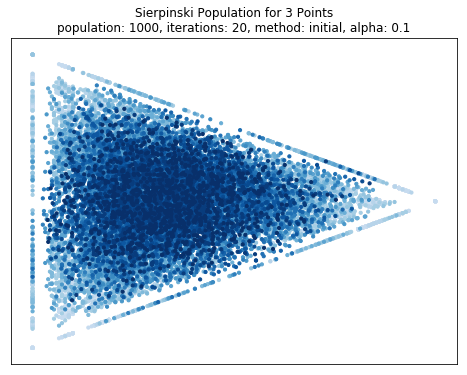

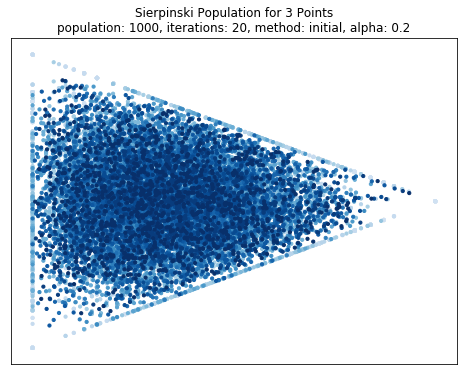

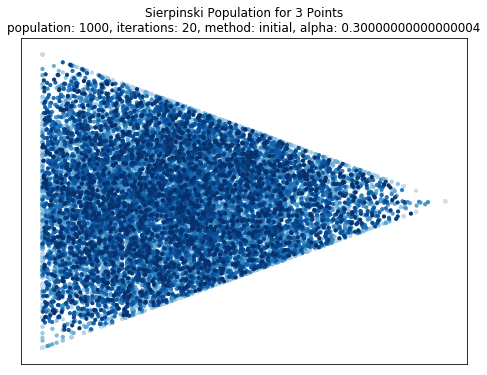

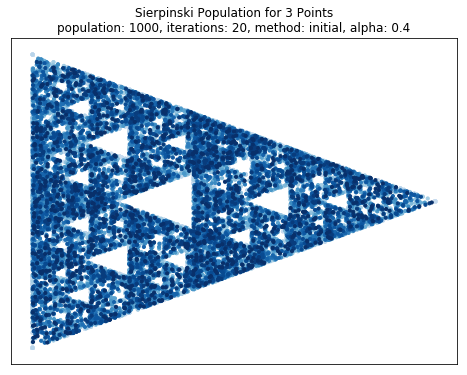

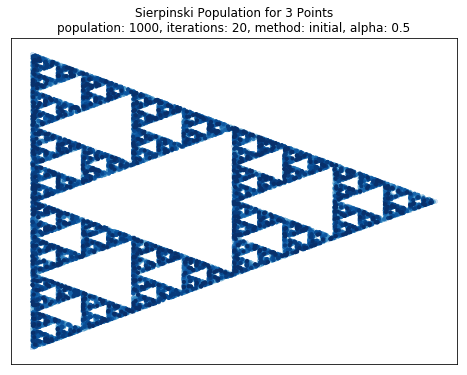

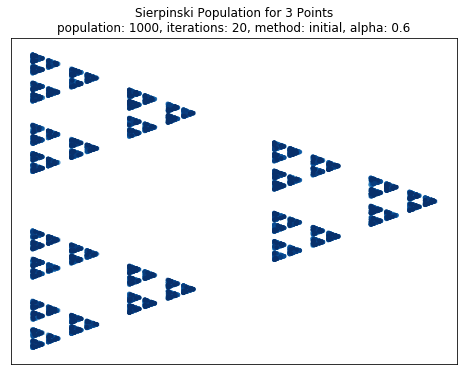

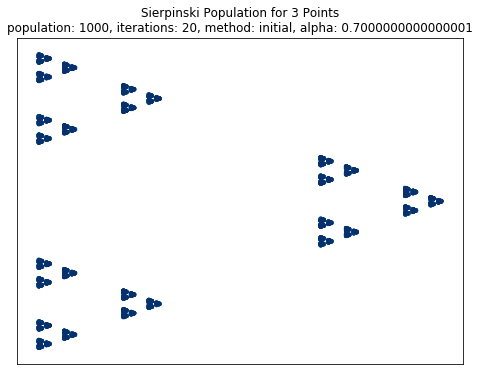

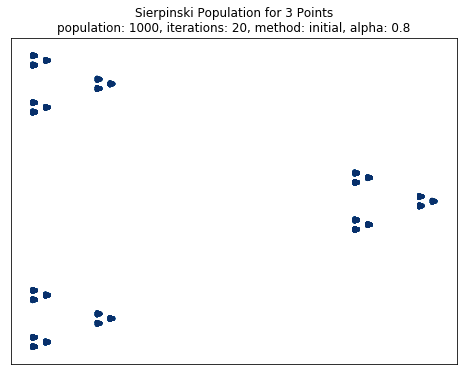

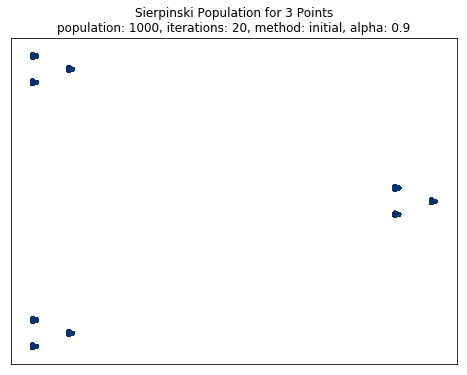

In [44]:
# Plot Sierpinski convergence, when alpha=0.5 and method='current'
# Using the current population as anchors leads to convergence 
# alphas = np.linspace(0.01, 0.99, 99)
alphas = np.linspace(0.1, 0.9, 9)
print(alphas)
pop_sizes = [1000]
num_steps_list = [20]
methods = ['initial']
points_list = [initial_2d_sierpinski_points(3)]
plot_sierpinski_experiment(points_list=points_list, methods=methods, pop_sizes=pop_sizes,
                           num_steps_list=num_steps_list, alphas=alphas)
                
                
                                           

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


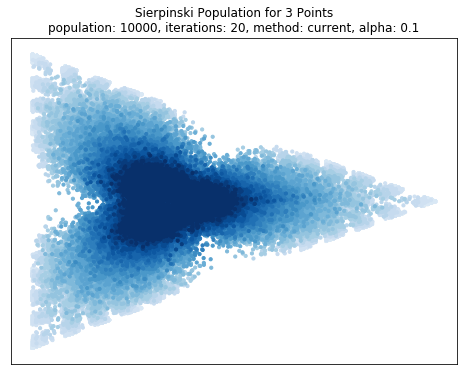

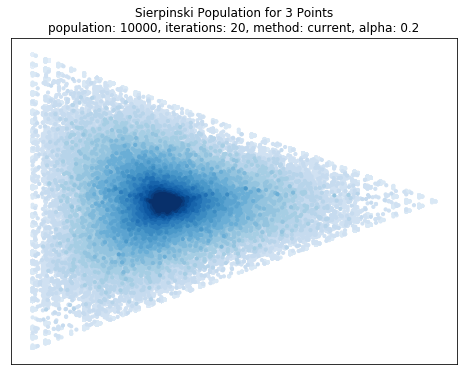

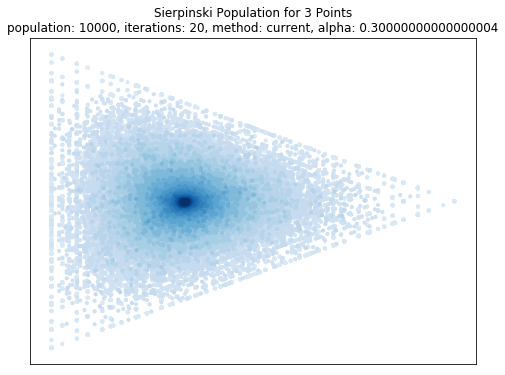

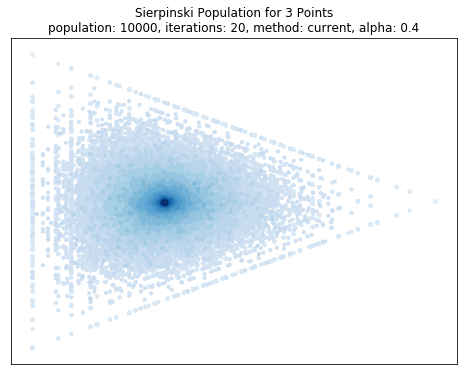

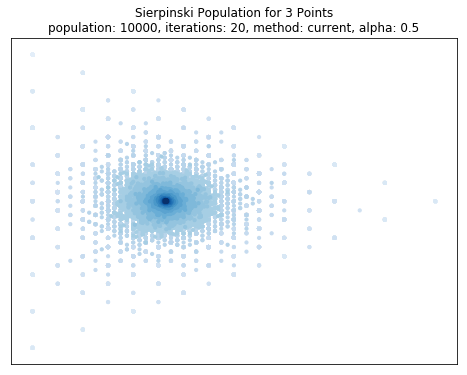

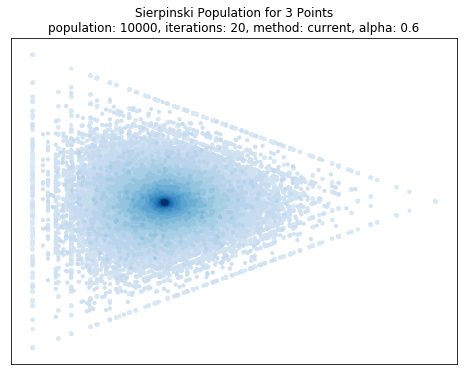

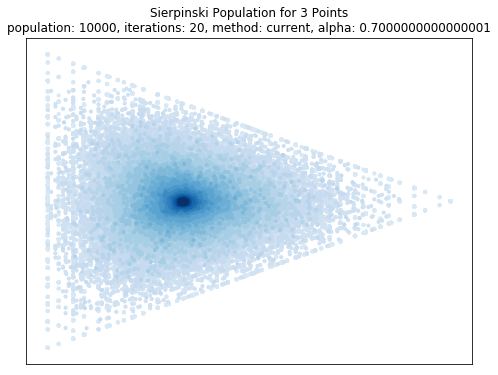

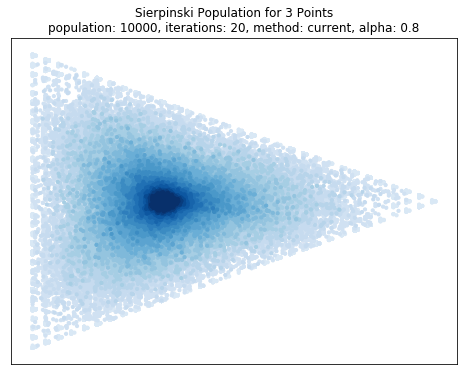

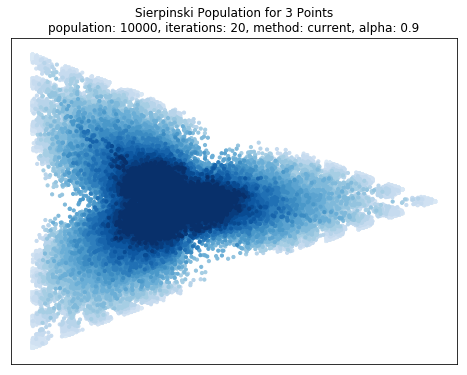

In [112]:
# Plot Sierpinski convergence, when alpha=0.5 and method='current'
# Using the current population as anchors leads to convergence 
# alphas = np.linspace(0.01, 0.99, 99)
alphas = np.linspace(0.1, 0.9, 9)
print(alphas)
pop_sizes = [10000]
num_steps_list = [20]
methods = ['current']
points_list = [initial_2d_sierpinski_points(3)]
plot_sierpinski_experiment(points_list=points_list, methods=methods, pop_sizes=pop_sizes,
                           num_steps_list=num_steps_list, alphas=alphas)
                
                
                                           

## Population-Based Methods

There is no compelling need to calculate the points in a Sierpinski set using a population. Reading about Population-based Training [Jaderberg 2017](https://arxiv.org/abs/1711.09846) inspired me to explore its use.

I thought it would be interesting to investigate the effect of different population based methods on the Sierpinski family of sets, comparing across different learning rates. Most population based methods take advantage of the fitness of a population of points to better search the space of points. Some population methods like Evolution Strategies generate a child population from a mean and standard deviation estimated from an front. See David Ha's [A Visual Guide to Evolution Strategies](http://blog.otoro.net/2017/10/29/visual-evolution-strategies/). 

The shape of the Chaos Game matches a population structured computation. During replication, the next iteration steps the current population toward a randomly selected anchor point.

What happens if instead of stepping toward the anchor points, the population steps towards the front.

Next look at:

- Random initialization
- Random noise (otherwise how can they reach the optimum?)
- Protected childhood, like PBT.


In [18]:


def make_random_initializer(num_params):
    def func(pop_size):
        '''Return a population of uniform random points in '''
        xs = np.random.random(pop_size) * 2 - 1 # [-1, 1)
        ys = np.random.random(pop_size) * 2 - 1 # [-1, 1)
        dimdata = [np.random.random(pop_size) * 2 - 1 for _ in range(num_params)]
        return np.stack(dimdata, axis=1) # (pop_size, num_params)

    return func


def anchor_distance_fitness(anchors, pop):
    deltas = (anchors.reshape((anchors.shape[0], 1, anchors.shape[1])) -
              pop.reshape(1, pop.shape[0], pop.shape[1]))
    return -np.mean(deltas * deltas, axis=-1).min(axis=0) 

    
def fittest_front(fits, rate=None, size=None):
    if rate is not None:
        front_size = int(np.ceil(len(fits) * rate))
    else:
        front_size = size
    # the front of fittest individuals 
    rand_idx = np.random.permutation(len(fits)) # randomize tie breaks?
    front_idx = np.argsort(fits[rand_idx])[::-1][:front_size] # reverse sort to choose the highest fitness
    return front_idx
    

class ChaosGamePopulation:
    '''
    Initialize population as randomly chosen anchors.
    Step population toward randomly chosen anchors.

    This is the game that produces points in the Sierpinski triangle 
    when the anchors are the corners of a triangle and alpha = 0.5.
    '''
    def __init__(self, anchors, pop_size, alpha):
        self.anchors = anchors 
        self.size = pop_size
        self.alpha = alpha # learning rate: size of step toward "correct" point

    def reset(self):
        self.pop = self.anchors[np.random.choice(len(self.anchors), size=self.size)]
        return self.pop
    
    def step(self):
        # population members each step toward a random anchor
        rand_parents = self.anchors[np.random.choice(len(self.anchors), size=self.size)]
        self.pop = (1 - self.alpha) * self.pop + self.alpha * rand_parents
        return self.pop
        

class RandomInitGamePopulation:
    '''
    Like ChaosGamePopulation, but population is initialized randomly, not at
    the anchor points.
    '''
    def __init__(self, anchors, pop_size, alpha):
        self.anchors = anchors 
        self.size = pop_size
        self.alpha = alpha # learning rate: size of step toward "correct" point
        
    def reset(self):
        '''Return a population of 2-d uniform random points in a box around zero.'''
        num_params = self.anchors.shape[1]
        data = [np.random.random(self.size) * 2 - 1 for _ in range(num_params)]
        self.pop = np.stack(data, axis=1) # (pop_size, num_params)
        return self.pop
        
    def step(self):
        # population members each step toward a random anchor
        rand_parents = self.anchors[np.random.choice(len(self.anchors), size=self.size)]
        self.pop = (1 - self.alpha) * self.pop + self.alpha * rand_parents
        return self.pop


class FrontGamePopulation:
    '''
    Like ChaosGamePopulation, but population steps toward the fitness frontier, not
    the anchor points.
    '''
    def __init__(self, anchors, pop_size, alpha, front_rate):
        self.anchors = anchors 
        self.size = pop_size
        self.alpha = alpha # learning rate: size of step toward "correct" point
        self.rate = front_rate
        
    def reset(self):
        self.pop = self.anchors[np.random.choice(len(self.anchors), size=self.size)]
        return self.pop
    
    def step(self):
        # the front of fittest individuals 
        self.fits = anchor_distance_fitness(self.anchors, self.pop)
        front_idx = fittest_front(self.fits, self.rate)

        # make children by stepping population towards the front
        rand_parents = self.pop[front_idx[np.random.choice(len(front_idx), size=self.size)]]
        self.pop = (1 - self.alpha) * self.pop + self.alpha * rand_parents
        return self.pop

    
class NoisyFrontPopulation:
    '''
    Initialize population at anchors.
    Step population toward front. Front comes from population.
    Add noise to the step to change exploration.
    
    Hypothesis: Noise allows points to step "outward" toward the anchor points
    allowing the front to stay closer to anchors than FrontPopulation.
    '''
    def __init__(self, anchors, pop_size, alpha, front_rate, noise_rate):
        self.anchors = anchors 
        self.size = pop_size
        self.alpha = alpha # learning rate: size of step toward "correct" point
        self.rate = front_rate
        self.noise_rate = noise_rate # std dev of normal noise to add to params.
        
    def reset(self):
        self.pop = self.anchors[np.random.choice(len(self.anchors), size=self.size)]
        self.pop += np.random.randn(*self.pop.shape) * self.noise_rate
        return self.pop
    
    def step(self):
        # the front of fittest individuals 
        self.fits = anchor_distance_fitness(self.anchors, self.pop)
        front_idx = fittest_front(self.fits, self.rate)

        # make children by stepping population towards the front
        rand_parents = self.pop[front_idx[np.random.choice(len(front_idx), size=self.size)]]
        self.pop = (1 - self.alpha) * self.pop + self.alpha * rand_parents
        self.pop += np.random.randn(*self.pop.shape) * self.noise_rate
        return self.pop

    
class SeparateFrontPopulation:
    '''
    The population is initialized from anchors.
    The front are the fittest among the parents and the front.
    Children always take a step in direction of the front.
    
    The front never loses the anchor points due to the distance fitness. 
    If large enough, it can contain other nearby points.
    '''
    def __init__(self, anchors, pop_size, alpha, front_rate):
        '''
        anchors: points used to initialize network and in fitness function.
        pop_size: 
        alpha: the length of the step taken from parent to point on the fitness frontier.
          0.5 is the rate used in the Chaos Game.
        front_rate: the proportion of the population selected for the front.
        '''
        self.anchors = anchors 
        self.size = pop_size
        self.alpha = alpha # learning rate: size of step toward "correct" point
        self.rate = front_rate
        self.front_size = int(np.ceil(self.size * self.rate))
        
    def reset(self):
        self.pop = self.anchors[np.random.choice(len(self.anchors), size=self.size)]
        self.fits = anchor_distance_fitness(self.anchors, self.pop)
        self.front = np.zeros((0, self.pop.shape[1])) # empty front
        self.front_fits = np.zeros(0)
        return self.pop
            
    def step(self):
        # the front is the fittest individuals of the front and population
        all_pop = np.vstack([self.pop, self.front])
        all_fits = np.hstack([self.fits, self.front_fits])
        front_idx = fittest_front(self.fits, size=self.front_size)
        self.front = all_pop[front_idx]
        self.front_fits = all_fits[front_idx]
#         print('front', self.front)
#         print('front_fits', self.front_fits)
        # make children by stepping population towards the front
        rand_parents = self.front[np.random.choice(len(front_idx), size=self.size)]
        self.pop = (1 - self.alpha) * self.pop + self.alpha * rand_parents
        return self.pop
        

class FrontSelectionPopulation:
    '''
    The front are the fittest parents. 
    Children always take a step in direction of the front.
    The next generation is selected from the fittest of the combined set of parents and children.
    
    Since the initial population is initialized from the anchors, no children can ever have
    better fitness (be closer to an anchor). So to population never leaves the anchor points.
    Boring.
    '''
    def __init__(self, anchors, pop_size, alpha, front_rate):
        '''
        anchors: points used to initialize network and in fitness function.
        pop_size: 
        alpha: the length of the step taken from parent to point on the fitness frontier.
          0.5 is the rate used in the Chaos Game.
        front_rate: the proportion of the population selected for the front.
        '''
        self.anchors = anchors 
        self.size = pop_size
        self.alpha = alpha # learning rate: size of step toward "correct" point
        self.rate = front_rate
        
    def reset(self):
        self.pop = self.anchors[np.random.choice(len(self.anchors), size=self.size)]
        return self.pop
    
    def step(self):
        # the front of fittest individuals 
        self.fits = anchor_distance_fitness(self.anchors, self.pop)
        front_idx = fittest_front(self.fits, self.rate)

        # make children by stepping population towards the front
        rand_parents = self.pop[front_idx[np.random.choice(len(front_idx), size=self.size)]]
        next_pop = (1 - self.alpha) * self.pop + self.alpha * rand_parents
        next_fits = self.evaluate(next_pop)
        
        # next population combines the best parents and children
        all_pop = np.vstack([self.pop, next_pop])
        all_fits = np.hstack([self.fits, next_fits])
        next_idx = np.argsort(all_fits)[::-1][:self.size]
#         print('next_idx', next_idx)
        self.pop = all_pop[next_idx]
        self.fits = all_fits[next_idx]
        return self.pop
           
    
def get_population(anchors, pop_size, alpha, front_rate, method, noise_rate=0.0):
    if method == 'ChaosGamePopulation':
#         print('ChaosGamePopulation')
        pop = ChaosGamePopulation(anchors=anchors, pop_size=pop_size, alpha=alpha)
    elif method == 'FrontGamePopulation':
        pop = FrontGamePopulation(anchors=anchors, pop_size=pop_size, alpha=alpha, front_rate=front_rate)
    elif method == 'RandomInitGamePopulation':
        pop = RandomInitGamePopulation(anchors=anchors, pop_size=pop_size, alpha=alpha)
    elif method == 'SeparateFrontPopulation':
        pop = SeparateFrontPopulation(anchors=anchors, pop_size=pop_size, alpha=alpha, front_rate=front_rate)
    elif method == 'NoisyFrontPopulation':
        pop = NoisyFrontPopulation(anchors=anchors, pop_size=pop_size, alpha=alpha, front_rate=front_rate,
                                   noise_rate=noise_rate)
    elif method == 'FrontSelectionPopulation':
        pop = FrontSelectionPopulation(anchors=anchors, pop_size=pop_size, alpha=alpha, front_rate=front_rate)
    else:
        raise Exception('Unknown method', method, anchors, pop_size, alpha, front_rate)
    return pop
        
        
def get_points(pop, num_steps):
    '''
    returns tuple of (points, gens), as numpy arrays.
    '''
    points = list(pop.reset())
    gens = [0] * len(points)
    for gen in range(1, num_steps + 1):
        next_points = pop.step()
        points.extend(next_points)
        gens.extend([gen] * len(next_points))
                            
    return np.array(points), np.array(gens)
    

def get_plot_title(anchors, pop_size, num_steps, alpha, front_rate, method, noise_rate=0.0):
    title = f'Sierpinski Population for {len(anchors)} Points'
    title += f'\npopulation: {pop_size}, iterations: {num_steps}'
    title += f', front: {front_rate:0.2f}, alpha: {alpha:.2f}'
    title += f'\nmethod: {method}, noise: {noise_rate}'
    return title
    

def plot_points(points, gens, title, s=None):
    plt.figure(figsize=(8, 6))
    norm = matplotlib.colors.Normalize(vmin=0, vmax=gens.max())
    s = 0.1 if s is None else s
#     colors = gens / gens.max()
    plt.scatter(x=points[:,0], y=points[:,1], c=gens, s=s, norm=norm, cmap='Blues')
    plt.title(title)
    plt.tick_params(bottom=False, top=False, left=False, right=False,
                    labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    plt.show()


def plot_sierpinksi_set(anchors, pop_size, num_steps, alpha, front_rate, method, noise_rate=0.0):
    title = get_plot_title(anchors, pop_size, num_steps, alpha, front_rate, method, noise_rate=0.0)
    pop = get_population(anchors, pop_size, alpha, front_rate, method, noise_rate=0.0)
    points, gens = get_points(pop, num_steps)
    plot_points(points, gens, title)
    
    
def animate_sierpinski_set(anchors, pop_size, num_steps, method, alphas, front_rates,
                           s=10, interval=200, filename=None, noise_rates=[0.0]):
    '''
    filename: if not None, save to filename. Otherwise return as HTML
    '''
    # https://stackoverflow.com/questions/9401658/how-to-animate-a-scatter-plot
    
    fig, ax = plt.subplots()
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    s = 0.1 if s is None else s
    scat = ax.scatter(x=[], y=[], c=[], s=s, cmap='Blues')
    def make_title(num_anchors=None, pop_size=None, num_steps=None, front_rate=None, alpha=None, 
                  noise_rate=None):
        alpha = 0 if alpha is None else alpha
        front_rate = -1 if front_rate is None else front_rate
        noise_rate = 0.0 if noise_rate is None else noise_rate
        title = f'Sierpinski Population for {num_anchors} Points'
        title += f'\npopulation: {pop_size}, iterations: {num_steps}'
        title += f', front: {front_rate:0.2f}, alpha: {alpha:.2f}'
        title += f'\nmethod: {method}, noise: {noise_rate:.2f}'
        return title
    text = ax.set_title(make_title())
    ax.tick_params(bottom=False, top=False, left=False, right=False,
                    labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    
    params = []
    for front_rate in front_rates:
        for alpha in alphas:
            for noise_rate in noise_rates:
                params.append((alpha, front_rate, noise_rate))

    def init():
        return scat, text

    def animate(params):
        alpha, front_rate, noise_rate = params
        pop = get_population(anchors, pop_size, alpha, front_rate, method, noise_rate)
        points, gens = get_points(pop, num_steps)
        colors = gens / gens.max()
        scat.set_offsets(np.array(points)) # x, y
        scat.set_sizes(np.full(pop_size * num_steps, s)) # s
        scat.set_array(np.array(colors)) # c
        text.set_text(make_title(num_anchors=len(anchors), pop_size=pop_size,
                                 num_steps=num_steps, front_rate=front_rate, alpha=alpha,
                                 noise_rate=noise_rate))
        return scat, text

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=params,
#                                    interval=interval,
                                   blit=True)
    if filename is not None:
        num_frames = len(params)
        fps = int(np.ceil(1000 / interval))
        writer = animation.FFMpegWriter(fps=fps)
        return anim.save(filename, writer=writer, dpi=180)
    else:
        return HTML(anim.to_html5_video())

    


alphas [1.0]
front_rates [0.1]
noise_rates [0.0]
num_anchors: 4


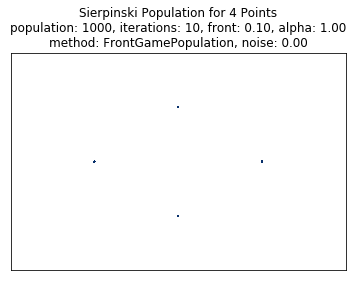

In [22]:
# Using the current population as anchors leads to convergence 
# alphas = np.linspace(0.01, 1.99, 199)
# alphas = np.linspace(0.01, 1.00, 100)
# alphas = np.linspace(0.90, 0.99, 10)
alphas = [1.0]
# alphas = np.linspace(0.1, 1.9, 19)
# alphas = np.linspace(0.1, 0.9, 9)
# alphas = np.linspace(0.9, 0.99, 10)
pop_sizes = [1000]
num_steps_list = [10]
# anchors_list = [initial_2d_sierpinski_points(i) for i in [2, 3, 4, 5, 6, 7, 8, 9, 16, 25, 100]] # 
anchors_list = [initial_2d_sierpinski_points(i) for i in [4]] # 
front_rates = [0.1]
# front_frates = np.linspace(0.1, 1.0, 10)
# fronts = np.linspace(0.1, 1.0, 10)
# methods = ['ChaosGamePopulation']
# methods = ['RandomInitGamePopulation']
methods = ['FrontGamePopulation']
# methods = ['SeparateFrontPopulation']
# methods = ['FrontGamePopulation', 'NoisyFrontPopulation']
# methods = ['NoisyFrontPopulation']
# methods = ['ChaosGamePopulation', 'RandomInitGamePopulation', 'FrontGamePopulation', 'SeparateFrontPopulation', 'NoisyFrontPopulation']
# methods = ['SierpinskiFrontPopulation']
noise_rates = [0.0]
# noise_rates = np.linspace(0.0, 1.0, 101)
print('alphas', alphas)
print('front_rates', front_rates)
print('noise_rates', noise_rates)
for anchors in anchors_list:
    print('num_anchors:', len(anchors))
    for pop_size in pop_sizes:
        for num_steps in num_steps_list:
            for method in methods:
#                 for noise_rate in noise_rates:
#                     for front_rate in front_rates:
#                         for alpha in alphas:
#                             plot_sierpinksi_set(anchors, pop_size, num_steps, alpha, front_rate, method, 
#                                                 noise_rate=noise_rate)

                filename = str(Path(f'~/Downloads/{len(anchors)} Point {method} Population.mp4').expanduser())
                filename = None
                html = animate_sierpinski_set(anchors, pop_size, num_steps, method, alphas, front_rates,
                           filename=filename, s=.1, noise_rates=noise_rates)
                display(html)


In [23]:
# Using the current population as anchors leads to convergence 
# alphas = np.linspace(0.01, 1.99, 199)
# alphas = np.linspace(0.01, .99, 99)
# alphas = np.linspace(0.1, 1.9, 19)
alphas = np.linspace(0.1, 0.9, 9)
print(alphas)
pop_sizes = [1000]
num_steps_list = [10]
# anchors_list = [initial_2d_sierpinski_points(i) for i in [2, 3, 4, 5, 6, 7, 8, 9, 16, 25, 100]] # 
anchors_list = [initial_2d_sierpinski_points(i) for i in [4]] # 
methods = ['ChaosGamePopulation']
front_rates = [1.0]
# methods = ['SierpinskiFrontPopulation']
for anchors in anchors_list:
    print('num_anchors:', len(anchors))
    # make an animation of the anchors
#     filename = str(Path(f'~/Downloads/{len(anchors)} Point Sierpinski Front Population as Front and Alpha Vary.mp4').expanduser())
    filename = None
    html = animate_sierpinski_sets(anchors_list=[anchors], pop_sizes=pop_sizes,
                                         num_steps_list=num_steps_list, alphas=alphas,
                                         filename=filename, s=.1, front_rates=front_rates, methods=methods)
    display(html)
                

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
num_anchors: 4


NameError: name 'animate_sierpinski_sets' is not defined

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
num_anchors: 4


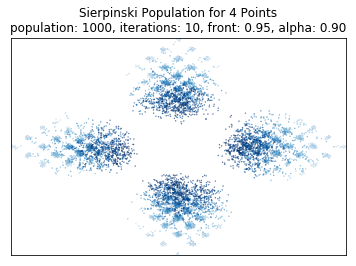

In [93]:
# Using the current population as anchors leads to convergence 
# alphas = np.linspace(0.01, 1.99, 199)
# alphas = np.linspace(0.01, .99, 99)
# alphas = np.linspace(0.1, 1.9, 19)
alphas = np.linspace(0.1, 0.9, 9)
print(alphas)
pop_sizes = [1000]
num_steps_list = [10]
# anchors_list = [initial_2d_sierpinski_points(i) for i in [2, 3, 4, 5, 6, 7, 8, 9, 16, 25, 100]] # 
anchors_list = [initial_2d_sierpinski_points(i) for i in [4]] # 
fronts = [0.95]
# fronts = np.linspace(0.1, 1.0, 10)
methods = ['SierpinskiFrontChaosPopulation']
# methods = ['SierpinskiFrontPopulation']
for anchors in anchors_list:
    print('num_anchors:', len(anchors))
    # make an animation of the anchors
#     filename = str(Path(f'~/Downloads/{len(anchors)} Point Sierpinski Front Population as Front and Alpha Vary.mp4').expanduser())
    filename = None
    html = animate_sierpinski_sets(anchors_list=[anchors], pop_sizes=pop_sizes,
                                         num_steps_list=num_steps_list, alphas=alphas,
                                         filename=filename, s=.1, fronts=fronts, methods=methods)
    display(html)
                

[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42
 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56
 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7
 0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84
 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98
 0.99]
num_anchors: 2


None

num_anchors: 3


None

num_anchors: 4


None

num_anchors: 5


None

num_anchors: 6


None

num_anchors: 7


None

num_anchors: 8


None

num_anchors: 9


None

num_anchors: 16


None

num_anchors: 25


None

num_anchors: 100


None

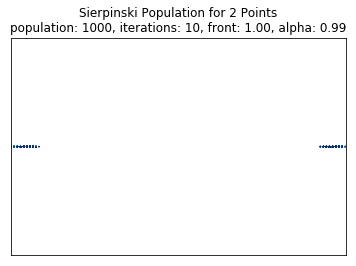

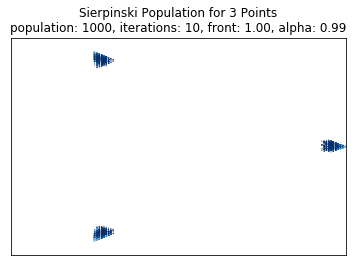

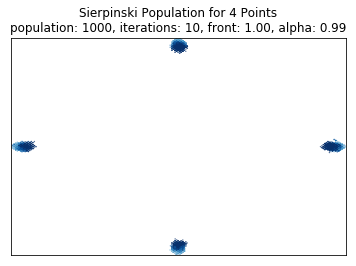

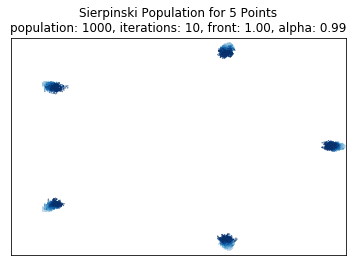

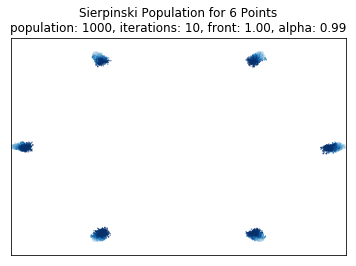

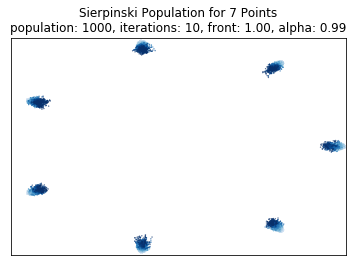

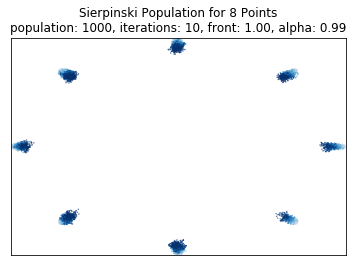

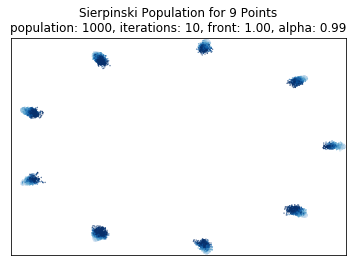

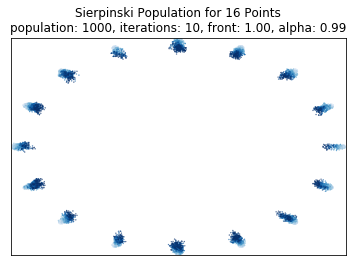

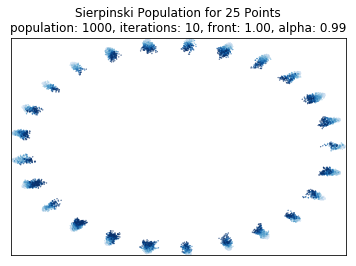

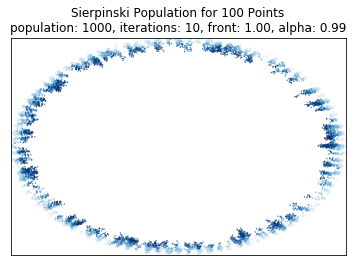

In [50]:
# Using the current population as anchors leads to convergence 
alphas = np.linspace(0.01, 0.99, 99)
# alphas = np.linspace(0.1, 0.9, 9)
print(alphas)
pop_sizes = [1000]
num_steps_list = [10]
anchors_list = [initial_2d_sierpinski_points(i) for i in [2, 3, 4, 5, 6, 7, 8, 9, 16, 25, 100]] # 
# anchors_list = [initial_2d_sierpinski_points(i) for i in [100]] # 
fronts = np.linspace(0.1, 1.0, 10)
methods = ['SierpinskiFrontChaosPopulation']
for anchors in anchors_list:
    print('num_anchors:', len(anchors))
    # make an animation of the anchors
    filename = str(Path(f'~/Downloads/{len(anchors)} Point Sierpinski Population as Front and Alpha Vary.mp4').expanduser())
#     filename = None
    html = animate_sierpinski_sets(anchors_list=[anchors], pop_sizes=pop_sizes,
                                         num_steps_list=num_steps_list, alphas=alphas,
                                         filename=filename, s=.1, fronts=fronts, methods=methods)
    display(html)
                